# About

Looks at the asymptotic trends of Omega, phi of a single .mat file. Then, plug results into theoretical N-limit equation to see if the global frequency and distribution agrees.

# Libraries

In [1]:
from __future__ import division, print_function

%matplotlib inline
import os
import numpy as np
from numpy.polynomial.polynomial import polyval
import scipy.io as sio
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.transforms as tsfm
import math
from math import pi

from lib import *

from IPython.display import clear_output

# Directories

In [2]:
# Data files
name_folder = 'matlab1'
name_file = 'sol30_gain30_1'

# Directory
dir_main = os.getcwd()
dir_mat = os.path.join(dir_main, 'data', name_folder, name_file)

# Import Data

In [3]:
# Import using Scipy
dict_mat = sio.loadmat(dir_mat)

sol = {}
sol['t'] = np.reshape(dict_mat['t'], -1)
sol['y'] = dict_mat['y']
sol['yp'] = dict_mat['yp']

# Parameters
param = {'g': dict_mat['g'][0,0],
        'omega0': dict_mat['omega0'][0,0],
        'a' : 1.0,
        'T' : dict_mat['T'][0,0],
        'gain': dict_mat['gain'][0,0],
        'N': dict_mat['N'][0,0],
        'tf': dict_mat['tf'][0,0]
        }

# Process Data

In [4]:
# Asymptotic percentage
asy = 0.1

# Compute the global frequency:
arr_omega = asylib.weight_avg(sol['t'], sol['yp'], asy)
asy_Omega = np.sum(arr_omega) / arr_omega.size

# Get array of asymptotic phases:
arr_lin = asy_Omega*sol['t']
arr_lin = arr_lin[:,None]

arr_diff = sol['y'] - arr_lin
asy_phases = asylib.weight_avg(sol['t'], arr_diff, asy)

asy_inds = np.arange(asy_phases.size)/asy_phases.size
unif_R = asy_phases[-1] - asy_phases[0]
sigma2 = np.var(arr_diff)

# Plot results

Natural frequency = 1
Asymptotic frequency = 0.6629384609490802
Asymptotic phase range = 0.36791119764849234


(array([5., 4., 4., 4., 3., 3., 3., 1., 1.]),
 array([0.        , 0.03679112, 0.07358224, 0.11037336, 0.14716448,
        0.1839556 , 0.22074672, 0.25753784, 0.29432896, 0.33112008]),
 <a list of 9 Patch objects>)

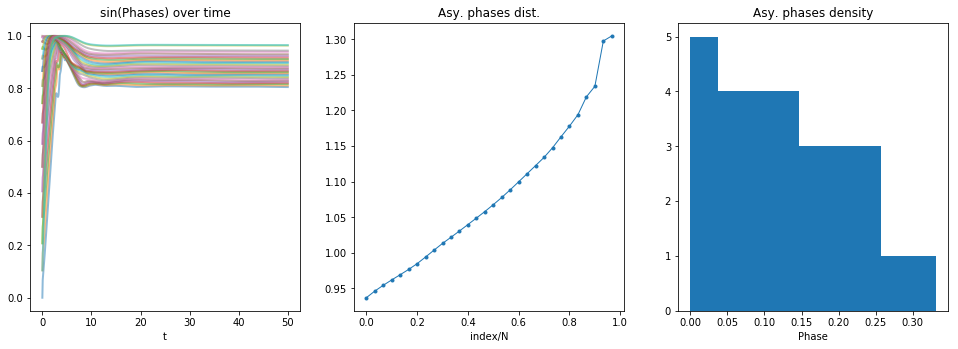

In [5]:
# Print asy values
print('Natural frequency = ' + str(param['omega0']))
print('Asymptotic frequency = ' + str(asy_Omega))
print('Asymptotic phase range = ' + str(unif_R))

# Configure plots
fig, ax = plt.subplots(3, figsize=(15,5))

# [left, bottom, width, height] 
bbox0 = [0.1, 0.1, 0.25, 0.8]
bbox1 = [0.40, 0.1, 0.25, 0.8]
bbox2 = [0.7, 0.1, 0.25, 0.8]

# Set ax positions
ax[0].set_position(bbox0)
ax[1].set_position(bbox1)
ax[2].set_position(bbox2)

# Set titles + axis labels
ax[0].set_title('sin(Phases) over time')
ax[1].set_title('Asy. phases dist.')
ax[2].set_title('Asy. phases density')

ax[0].set_xlabel('t')
ax[1].set_xlabel('index/N')
ax[2].set_xlabel('Phase')

# PLOT
ax[0].plot(sol['t'], np.sin(arr_diff), linewidth=2.0, alpha=0.5)
ax[1].plot(asy_inds, asy_phases, linestyle='-', linewidth=1.0, marker='.')
ax[2].hist(asy_phases - asy_phases[0], unif_R*np.arange(10)/10, density=False)

# Theoretical plots

Variance = 0.23281415313106016
Global Frequency = 0.6629384609490802
0.0032071786710764494


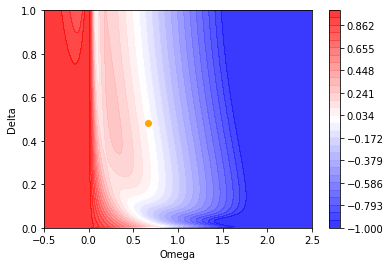

In [25]:
w0 = param['omega0']
g = param['g']
tau0 = param['T']
N_x = 1000

Omega_lin = np.linspace(w0-g, w0+g, num=200)
delta_lin = np.linspace(0, 1, num=200)

delta_mesh, Omega_mesh = np.meshgrid(delta_lin, Omega_lin)

err_mesh = np.zeros(Omega_mesh.shape)
err_fun = lambda u,v: w0 + g*funlib.phase_gauss(u, tau0, N_x, param, v) - u

for k in range(Omega_lin.size):
    for l in range(delta_lin.size):
        err = err_fun(Omega_mesh[k,l], delta_mesh[k,l])
        err = np.max((np.min((err, 1)), -1))
        err_mesh[k,l] = err

# Print error
print("Variance = " + str(sigma2))
print("Global Frequency = " + str(asy_Omega))
print(err_fun(asy_Omega, np.sqrt(sigma2)))

# Plot
# fig = plt.figure(figsize=(8,7))
# ax = fig.add_subplot(111, projection='3d')
fig, ax = plt.subplots(1,1)
ax.set_xlabel("Omega")
ax.set_ylabel("Delta")

# ax.plot_wireframe(Omega_mesh, delta_mesh, err_mesh)
# ax.plot_surface(Omega_mesh, delta_mesh, np.zeros(delta_mesh.shape), alpha=0.5)

alpha = 0.8
levels = np.linspace(-1, 1, 30)

CS = ax.contourf(Omega_mesh, delta_mesh, err_mesh, levels, cmap='bwr', alpha=alpha)
ax.autoscale(False)
ax.scatter(np.array([asy_Omega]), np.array([np.sqrt(sigma2)]), color='orange', zorder=1)

cbar = plt.colorbar(CS)

In [7]:
err_fun2 = lambda u,v: funlib.invar_err2(u, v, 1000, param)
x, y = err_fun2(asy_Omega, unif_R)

err = funlib.invar_err3(asy_Omega, asy_phases, param)
print(np.sum(err))
print(asy_Omega * dict_mat['gain'])
k = dict_mat['gain']
print(np.sin(-asy_Omega*tau0 + (1-asy_Omega*k)*pi))

TypeError: invar_err2() missing 1 required positional argument: 'param'

In [ ]:
# Plot the convolution sin function (f(a) = f())
gain = dict_mat['gain']
conv = lambda x: np.sin(-asy_Omega*np.maximum(tau0 - asy_Omega*gain*x, np.zeros(x.size)) - x)

fig, ax = plt.subplots(1,1)
x_array = np.linspace(-pi, pi, num=100)
y_array = np.reshape(conv(x_array), -1)

ax.plot(x_array, y_array)